In [1]:
import scipy.io as sio 
import warnings
warnings.filterwarnings('ignore')

train = sio.loadmat('./train.mat')
test = sio.loadmat('./test.mat')
print(train.keys())
print(test.keys())


x_train = train['X'].swapaxes(0,3).swapaxes(2,3).swapaxes(1,2)
y_train = train['y']
x_test = test['X'].swapaxes(0,3).swapaxes(2,3).swapaxes(1,2)
y_test = test['y']

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
x_train shape: (73257, 32, 32, 3)
y_train shape: (73257, 1)
73257 train samples
26032 test samples


In [2]:
y_train[y_train== 10] = 0
y_test[y_test== 10] = 0

# 使用一个通道训练模型，方便接PCA
x_train = x_train[:,:,:,0]
x_test = x_test[:,:,:,0]

# img_rows = 32
# img_cols = 32

# x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
# x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (73257, 32, 32)
x_test shape: (26032, 32, 32)


In [3]:
from keras.layers import Input, Dense
from keras.models import Model

import warnings
warnings.filterwarnings('ignore')
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(1024,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(1024, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

Using TensorFlow backend.


In [4]:
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [5]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
from keras.datasets import mnist
import numpy as np

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

autoencoder.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 73257 samples, validate on 26032 samples
Epoch 1/50
73257/73257 [==============================] - 4s 59us/step - loss: 0.6926 - val_loss: 0.6923
Epoch 2/50
73257/73257 [==============================] - 6s 78us/step - loss: 0.6914 - val_loss: 0.6912
Epoch 3/50
73257/73257 [==============================] - 7s 90us/step - loss: 0.6899 - val_loss: 0.6893
Epoch 4/50
73257/73257 [==============================] - 7s 93us/step - loss: 0.6873 - val_loss: 0.6851
Epoch 5/50
73257/73257 [==============================] - 6s 76us/step - loss: 0.6831 - val_loss: 0.6786
Epoch 6/50
73257/73257 [==============================] - 6s 84us/step - loss: 0.6781 - val_loss: 0.6704
Epoch 7/50
73257/73257 [==============================] - 7s 99us/step - loss: 0.6721 - val_loss: 0.6587
Epoch 8/50
73257/73257 [==============================] - 8s 110us/step - loss: 0.6646 - val_loss: 0.6483
Epoch 9/50
73257/73257 [==============================] - 7s 90us/step - loss: 0.6562 - val_loss: 0.6386
Epoc

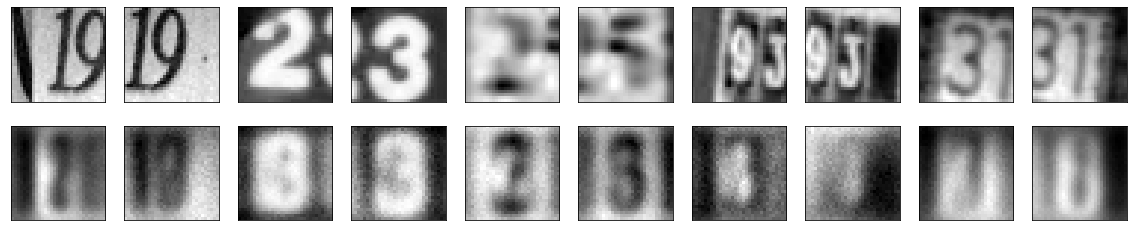

In [7]:

import matplotlib.pyplot as plt

encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(x_train[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(decoded_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

In [9]:
from sklearn.ensemble import RandomForestClassifier

GBDT = RandomForestClassifier()
GBDT.fit(x_train_encoded,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
y_pred = GBDT.predict(x_test_encoded)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 673  250  149   78  147   81  192   23   64   87]
 [  70 4157  233  179  281   48   41   67   12   11]
 [  86  877 2185  268  319   67   87  161   43   56]
 [  80  730  541  829  374  126   38   72   23   69]
 [  63  506   97   68 1632   19   78   14   23   23]
 [ 144  473  332  273  393  314  178   37  139  101]
 [ 253  347  119   48  317   92  644   17  108   32]
 [  31  610  501  138  111   17   33  551   16   11]
 [ 188  250  176   46  286  134  314    9  164   93]
 [ 203  271  220   81  337   93   91   33   99  167]]
              precision    recall  f1-score   support

           0       0.38      0.39      0.38      1744
           1       0.49      0.82      0.61      5099
           2       0.48      0.53      0.50      4149
           3       0.41      0.29      0.34      2882
           4       0.39      0.65      0.49      2523
           5       0.32      0.13      0.19      2384
           6       0.38      0.33      0.35      1977
           7       0.56      0.27   